In [1]:
import numpy as np
import scipy.sparse as sps
import scipy.sparse.linalg as linalg
import cv2
import matplotlib.pyplot as plt

In [2]:
def load_image(Ho, Wo, sz):
  image_data = {}
  source = cv2.imread("../Data/source.png") # nguồn
  mask = cv2.imread("../Data/mask.png") # mặt nạ
  target = cv2.imread("../Data/target.png") # ảnh đích
  resized_mask = cv2.resize(mask, (source.shape[1], source.shape[0]))
  source_resize = cv2.resize(source, None, fx=sz, fy=sz)

  # Resize mask
  mask_resize = cv2.resize(resized_mask, None, fx=sz, fy=sz)
  
  # chuẩn hoá ảnh
  image_data['source'] = cv2.normalize(source_resize.astype('float'), None, 0.0, 1.0, norm_type=cv2.NORM_MINMAX)
  image_data['mask'] = cv2.normalize(mask_resize.astype('float'), None, 0.0, 1.0, norm_type=cv2.NORM_MINMAX)
  image_data['target'] = cv2.normalize(target.astype('float'), None, 0.0, 1.0, norm_type=cv2.NORM_MINMAX)
  #image_data['dims'] = target_offsets[int(filename[:-4])-1]
  image_data['dims'] =[Ho, Wo]
  
  return image_data

def display_image(image_data):
#chiếu ảnh
  plt.figure(figsize=(16,16))
  for i in range(3):
    if(i == 0):
      img_string = 'source'
    elif(i == 1):
      img_string = 'mask'
    else:
      img_string = 'target'
    img = image_data[img_string]
    plt.subplot(1,3,i+1)
    plt.imshow(img[:,:,[2,1,0]])
    

In [3]:
def preprocess(image_data):
  # trích xuất ảnh
  source = image_data['source']
  mask = image_data['mask']
  target = image_data['target']
  
  # lấy hình dạng và offset của ảnh
  Hs,Ws,_ = source.shape
  Ht,Wt,_ = target.shape
  Ho, Wo = image_data['dims']
  
  # điều chỉnh nguồn và mặt nạ nếu offset âm.
  # nếu mặt nạ được cuộn lại, vd. từ đầu nó cuộn
  # xuống dưới cùng, cắt phần cuộn
  if(Ho < 0):
    mask = np.roll(mask, Ho, axis=0)
    source = np.roll(source, Ho, axis=0)
    mask[Hs+Ho:,:,:] = 0 # cắt phần thừa
    source[Hs+Ho:,:,:] = 0 #
    Ho = 0
  if(Wo < 0):
    mask = np.roll(mask, Wo, axis=1)
    source = np.roll(source, Wo, axis=1)
    mask[:,Ws+Wo:,:] = 1 # cắt phần thừa
    source[:,Ws+Wo:,:] = 1 #
    Wo = 0
  
  # vùng mặt nạ trên target
  H_min = Ho
  H_max = min(Ho + Hs, Ht)
  W_min = Wo
  W_max = min(Wo + Ws, Wt)
  
  # cắt ảnh nguồn và ảnh mặt nạ nếu chúng nằm ngoài giới hạn của mục tiêu
  source = source[0:min(Hs, Ht-Ho),0:min(Ws, Wt-Wo),:]
  mask = mask[0:min(Hs, Ht-Ho),0:min(Ws, Wt-Wo),:]
  
  return {'source':source, 'mask': mask, 'target': target, 'dims':[H_min,H_max,W_min,W_max]}
  

In [4]:
def get_subimg(image, dims):
   return image[dims[0]:dims[1], dims[2]:dims[3]]

def poisson_blending(image):
  # hàm so sánh
  def _compare(val1, val2):
    if(abs(val1) > abs(val2)):
      return val1
    else:
      return val2
  
  # màng (khu vực thực hiện pha trộn Poisson)
  mask = image['mask']
  Hs,Ws = mask.shape
  num_pxls = Hs * Ws
  
  # ảnh nguồn + ảnh đích
  source = image['source'].flatten(order='C')
  target_subimg = get_subimg(image['target'], image['dims']).flatten(order='C')

  # khởi tạo mặt nạ, trường vectơ hướng dẫn và laplacian
  mask = mask.flatten(order='C')
  guidance_field = np.empty_like(mask)
  laplacian = sps.lil_matrix((num_pxls, num_pxls), dtype='float64')

  for i in range(num_pxls):
    # xây dựng ma trận khối laplacian 
    # và guidance field
    if(mask[i] > 0.99):
      laplacian[i, i] = 4
      # xây dựng laplacian và tính toán gradient ảnh nguồn và  ảnh đích trong mặt nạ
      if(i - Ws > 0):
        laplacian[i, i-Ws] = -1
        Np_up_s = source[i] - source[i-Ws]
        Np_up_t = target_subimg[i] - target_subimg[i-Ws]
      else:
        Np_up_s = source[i]
        Np_up_t = target_subimg[i]
        
      if(i % Ws != 0):
        laplacian[i, i-1] = -1
        Np_left_s = source[i] - source[i-1]
        Np_left_t = target_subimg[i] - target_subimg[i-1]
      else:
        Np_left_s = source[i]
        Np_left_t = target_subimg[i]
        
      if(i + Ws < num_pxls):
        laplacian[i, i+Ws] = -1
        Np_down_s = source[i] - source[i+Ws]
        Np_down_t = target_subimg[i] - target_subimg[i+Ws]
      else:
        Np_down_s = source[i]
        Np_down_t = target_subimg[i]
        
      if(i % Ws != Ws-1):
        laplacian[i, i+1] = -1
        Np_right_s = source[i] - source[i+1]
        Np_right_t = target_subimg[i] - target_subimg[i+1]
      else:
        Np_right_s = source[i]
        Np_right_t = target_subimg[i]
      
      guidance_field[i] = (_compare(Np_up_s, Np_up_t) + _compare(Np_left_s, Np_left_t) + 
                           _compare(Np_down_s, Np_down_t) + _compare(Np_right_s, Np_right_t))

    else:
      # nếu điểm nằm bên ngoài màng, sao chép hàm target
      laplacian[i, i] = 1
      guidance_field[i] = target_subimg[i]
  
  return [laplacian, guidance_field]
  

In [5]:
#  giải bình phương tuyến tính nhỏ nhất 
def linlsq_solver(A, b, dims):
  x = linalg.spsolve(A.tocsc(),b)
  return np.reshape(x,(dims[0],dims[1]))

# khâu giải phương trình poisson với ảnh mục tiêu
def stitch_images(source, target, dims):
  target[dims[0]:dims[1], dims[2]:dims[3],:] = source
  return target

# thực hiện Poisson Blending
def blend_image(data):
  equation_param = []
  ch_data = {}
    
  # Xây dựng phương trình Poisson
  for ch in range(3):
    ch_data['source'] = data['source'][:,:,ch]
    ch_data['mask'] = data['mask'][:,:,ch]
    ch_data['target'] = data['target'][:,:,ch]
    ch_data['dims'] = data['dims']
    equation_param.append(poisson_blending(ch_data))
  
  # Giải Phương trình Poisson
  image_solution = np.empty_like(data['source'])
  for i in range(3):
    image_solution[:,:,i] = linlsq_solver(equation_param[i][0],equation_param[i][1],data['source'].shape)
      
  image_solution = stitch_images(image_solution, image['target'],ch_data['dims'])
     
  return image_solution


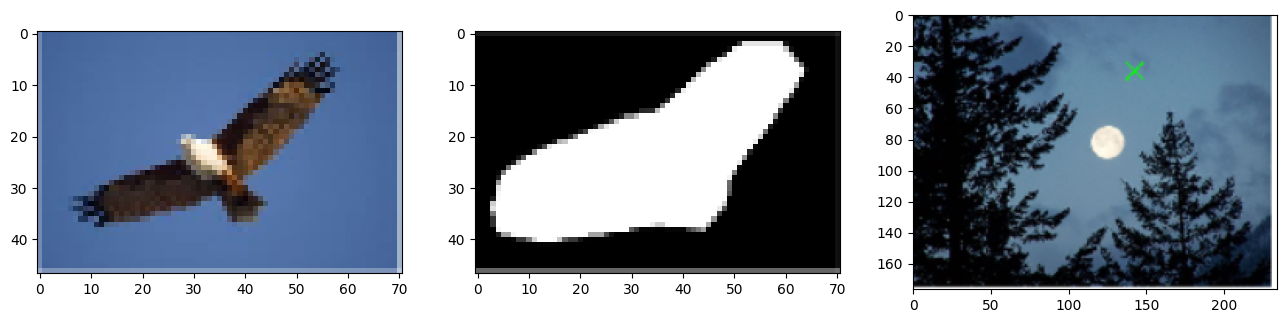

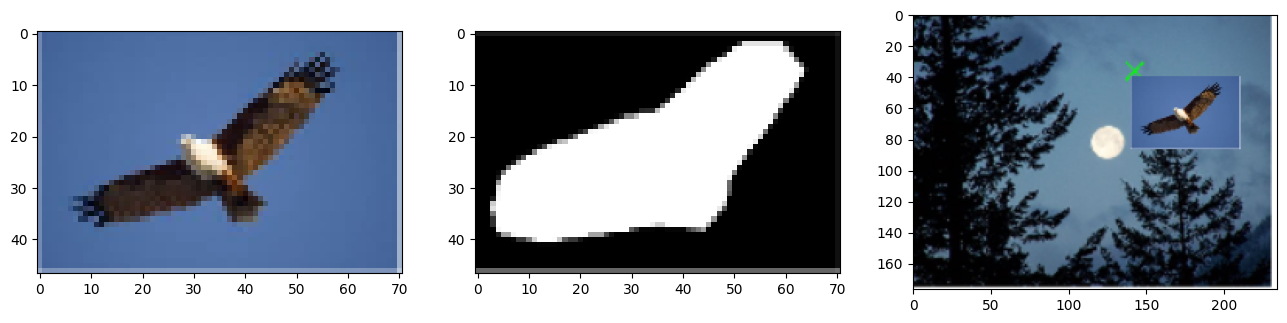

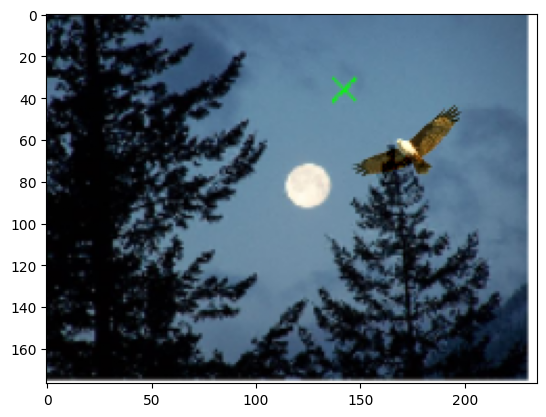

True

In [6]:

image = load_image(40, 140, 0.3)
display_image(image)
data = preprocess(image)
data2 = {'source': data['source'].copy(), 'mask': data['mask'].copy(), 'target': data['target'].copy(), 'dims': data['dims'].copy()}
data2['target'] = stitch_images(data2['source'], data2['target'], data2['dims'])
display_image(data2) 
final_image = blend_image(data) # áp dụng Poisson Blending 

#  kết quả
final_image = np.clip(final_image,0.0,1.0)
plt.figure()
plt.imshow(final_image[:, :, [2, 1, 0]])
plt.show()
final_image_cv2 = (final_image * 255).astype(np.uint8)

cv2.imwrite('../Data/final_result.jpg', final_image_cv2)
